In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataset = pd.read_excel('CTG.xls', sheet_name=1, skiprows=1) # Get the data

In [2]:
dataset.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,Unnamed: 9,...,E,AD,DE,LD,FS,SUSP,Unnamed: 42,CLASS,Unnamed: 44,NSP
0,240.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,NaN,9.0,NaN,2.0
1,5.0,632.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
2,177.0,779.0,2.0,0.0,5.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
3,411.0,1192.0,2.0,0.0,6.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
4,533.0,1147.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2.0,NaN,1.0


In [3]:
dataset = dataset.dropna(axis=1, how='all') # Got rid of empty columns
dataset = dataset.dropna(axis=0, how='any') # Three rows were REALLY missing information
dataset = dataset.drop(['b','e','DR','Tendency'], axis=1) # No information from such columns...

In [4]:
dataset.head()

,AC,FM,UC,DL,DS,DP,LB,AC.1,FM.1,UC.1,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.000000,0.0,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,9.0,2.0
1,4.0,0.0,4.0,2.0,0.0,0.0,132.0,0.006380,0.0,0.006380,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
2,2.0,0.0,5.0,2.0,0.0,0.0,133.0,0.003322,0.0,0.008306,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
3,2.0,0.0,6.0,2.0,0.0,0.0,134.0,0.002561,0.0,0.007682,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,4.0,0.0,5.0,0.0,0.0,0.0,132.0,0.006515,0.0,0.008143,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0


Distrubution of the different classes
---

C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


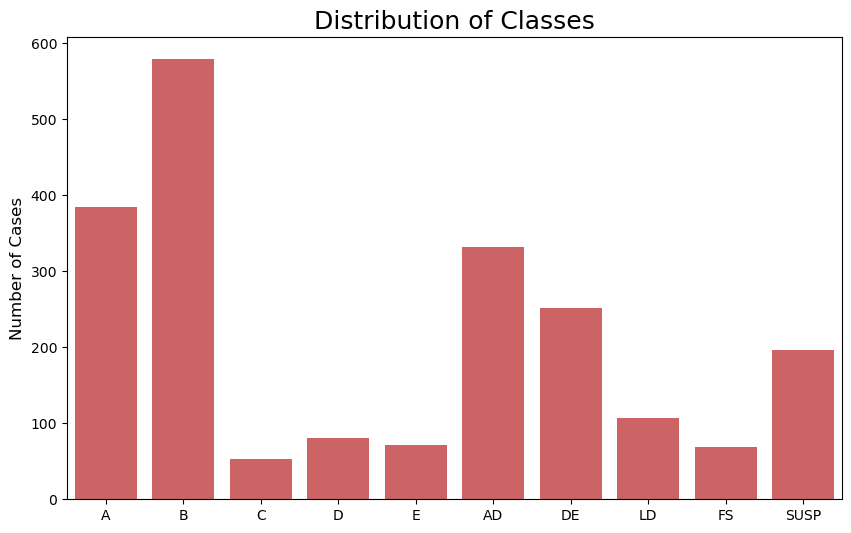

In [5]:
import matplotlib.cm as cm # To make pretty graphs
import seaborn as sns
color = sns.color_palette()

cnt_srs = dataset['CLASS'].value_counts()
cnt_srs = cnt_srs.head(10)
plt.figure(figsize=(10,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
N = 10
ind = np.arange(N) 
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'))
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Distribution of Classes', fontsize=18)
plt.show()

C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


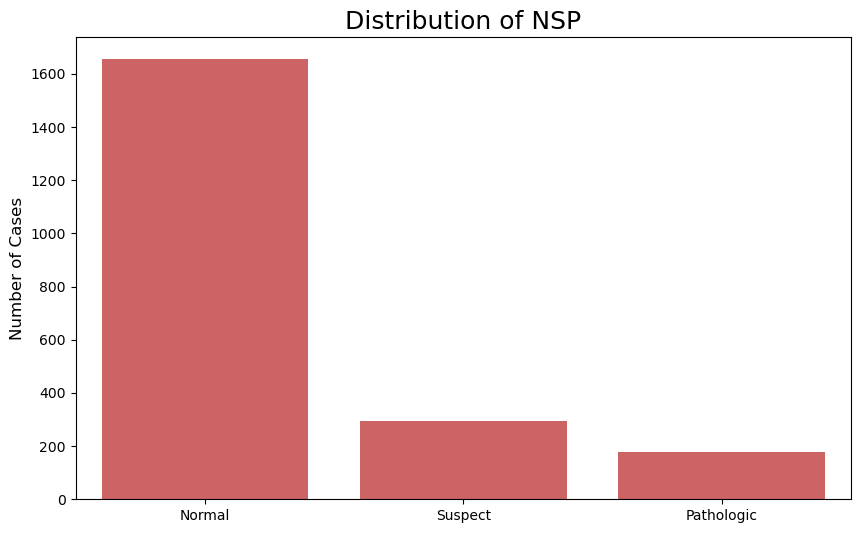

In [6]:
import matplotlib.cm as cm # To make pretty graphs
import seaborn as sns
color = sns.color_palette()

cnt_srs = dataset['NSP'].value_counts()
cnt_srs = cnt_srs.head(10)
plt.figure(figsize=(10,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
N = 3
ind = np.arange(N) 
plt.xticks(ind, ('Normal','Suspect', 'Pathologic'))
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Distribution of NSP', fontsize=18)
plt.show()

Distribution of the NSP in the fetus classes
---

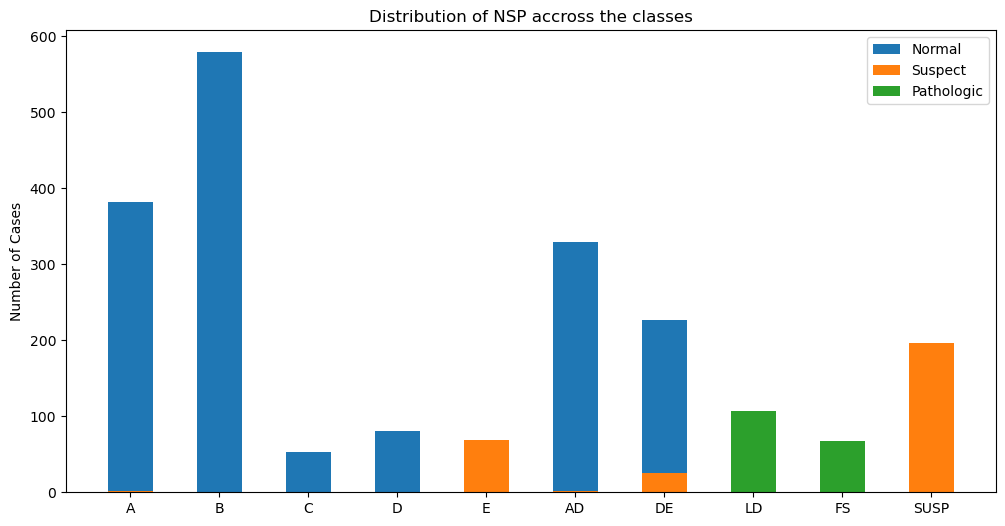

In [7]:
x = dataset[['CLASS','NSP']]
N = 10
zeroesddf = pd.DataFrame(data=np.zeros(10,),index=[1,2,3,4,5,6,7,8,9,10])

ind = np.arange(N)    # the x locations for the groups
width = 0.50    # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,6))

for nsp_i in [1,2,3]:
    norm = x.loc[(x['NSP']==nsp_i)].drop('NSP', axis=1)
    norm = (pd.value_counts(norm['CLASS'].values, sort=False)).sort_index()
    norm = pd.DataFrame(data=norm, index=norm.index)
    norm = zeroesddf.add(norm,axis='index',fill_value=0) 
    norm = (norm.values).reshape(-1)
    if nsp_i == 1 :
        p1 = plt.bar(ind,norm, width)
    elif nsp_i == 2 :
        p2 = plt.bar(ind,norm,width)
    elif nsp_i == 3 :
        p3 = plt.bar(ind,norm,width)
    
plt.ylabel('Number of Cases')
plt.title('Distribution of NSP accross the classes')
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'))
plt.legend((p1[0], p2[0], p3[0]), ('Normal', 'Suspect', 'Pathologic'))
plt.show()

C:\Users\prana\AppData\Local\Temp\ipykernel_3552\859486704.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

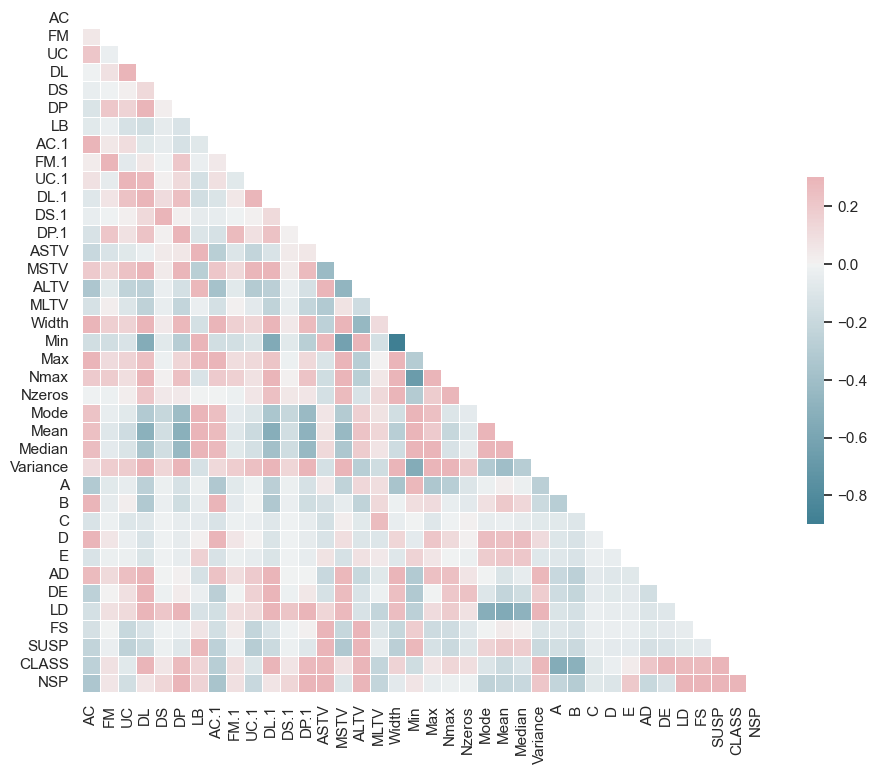

In [8]:
sns.set(style="white")
# Generate a large random dataset
d = dataset

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


First we need to process the data to a format that can fit these algorithms.

In [9]:
# Preparing our variables
X = dataset.iloc[:,:-2].values # We got rid of the class value to focus on the FHR diagnosis
y = dataset.iloc[:,-1].values # Containing the FHR diagnosis

# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

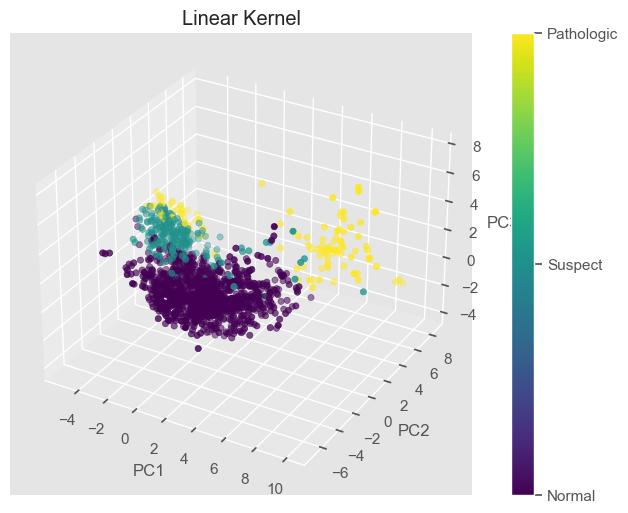

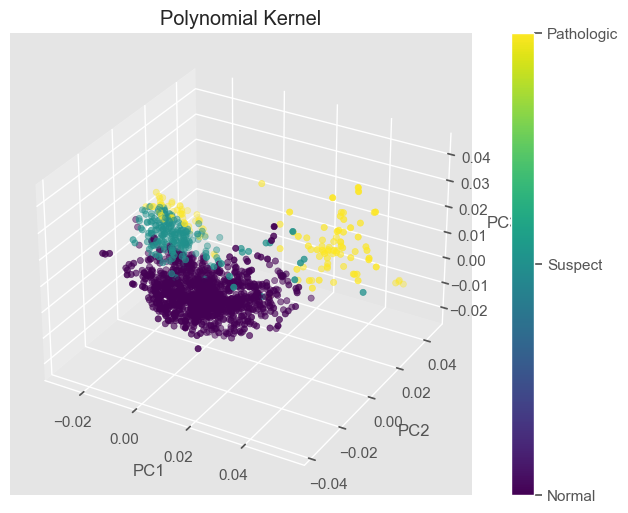

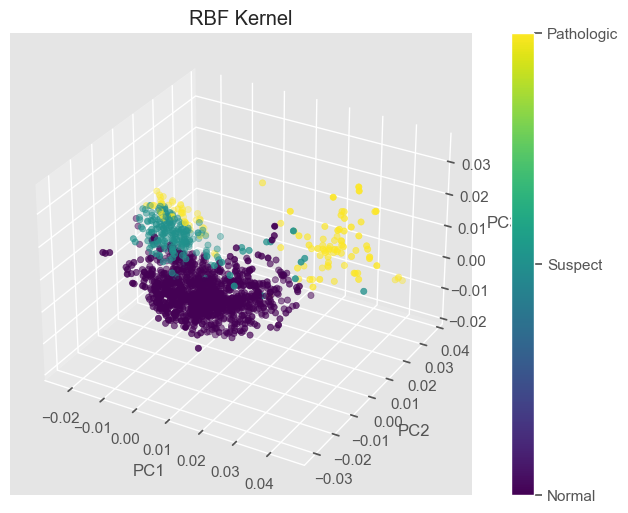

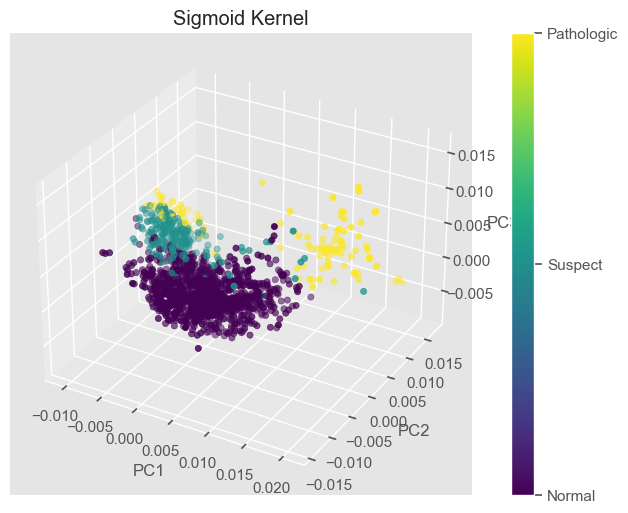

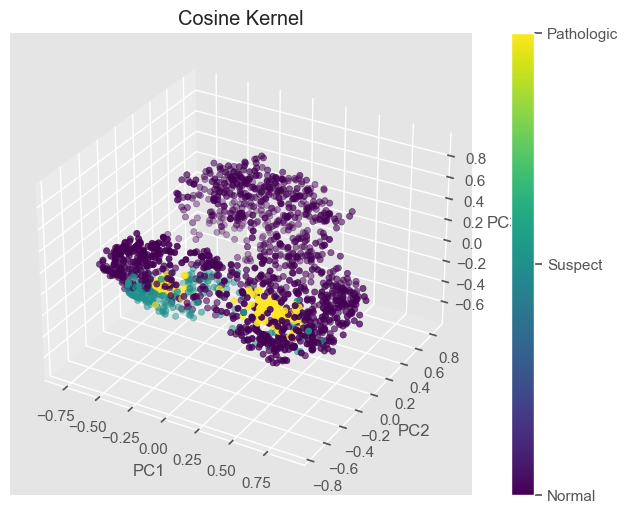

In [10]:
from sklearn.decomposition import KernelPCA

names = [
         'Linear Kernel',
         'Polynomial Kernel',
         'RBF Kernel',
         'Sigmoid Kernel',
         'Cosine Kernel'
         ]

classifiers = [
    KernelPCA(n_components = 3, kernel = 'linear'),
    KernelPCA(n_components = 3, kernel = 'poly', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'rbf', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'sigmoid', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'cosine')
]

models=zip(names,classifiers)
   
for name, kpca in models:
    X_PCA = kpca.fit_transform(X_train)
    
    from mpl_toolkits.mplot3d import axes3d
    from matplotlib import style
    style.use('ggplot')
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111, projection='3d')
    loc = [1,2,3]
    classes = ['Normal','Suspect','Pathologic']
    x3d = X_PCA[:,0]
    y3d = X_PCA[:,1]
    z3d = X_PCA[:,2]

    plot = ax1.scatter(x3d, y3d, z3d, c=y_train, cmap="viridis")
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    cb = plt.colorbar(plot)
    cb.set_ticks(loc)
    cb.set_ticklabels(classes)

    plt.title(name)
    plt.show()

Regardless of the kernels we used as examples and regardless of the different parameters we tried for such kernels off-screen, we could not get the PCA technique to represent the problem on a 3D graph in a way that was clear and understandable. We added the colors on the graphs to show where the different NSP groups were represented. It clearly shows that the PCA did not perform efficiently when it comes to separate the NSP groups. Yet, something interesting came out of it. Every kernel we used created two different groups for the "Pathologic" class of the NSP. One is always close to the "Suspect" group of points and one is always far from it. It shows a subclassification amongst the "Suspect" group, some of them being more prone to evolve in a pathology than others.


**Using an Autoencoder for Dimensionality reduction**

Autoencoders have proven their efficiency in many different cases. When it comes to dimensionality reduction we have yet to find a technique more elegant and more accurate. We're gonna build an autoencoder from scratch, use it to encode the data that we will then put on a 3D graph to compare it with our previous results. From here, we will refer to the autoencoder as AE.

In [11]:
#https://statcompute.wordpress.com/2017/01/15/autoencoder-for-dimensionality-reduction/

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from keras.layers import Input, Dense
from keras.models import Model

X = dataset.iloc[:,:-1].values # Put back the class value to use it later

 
# Feature scaling for the AE
sX = minmax_scale(X, axis = 0)
ncol = 36
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(sX, y, train_size = 0.8, random_state = seed(2017))
 
Class_train_auto = X_train_auto[:, 36] # These two columns will be used for comparison
Class_test_auto = X_test_auto[:,36]    # later on

X_train_auto = np.delete(X_train_auto, 36, 1)  # But theyr are not needed
X_test_auto = np.delete(X_test_auto, 36, 1)  # as of right now

input_dim = Input(shape = (ncol, ))

# Define the dimension of the encoder
encoding_dim = 3

# Define the encoder layer
encoded = Dense(encoding_dim, activation = 'relu')(input_dim)

# Define the decoder layer
decoded = Dense(ncol, activation = 'sigmoid')(encoded)

# Combine the layers into a model to create the AE
autoencoder = Model(inputs = input_dim, outputs = decoded)

# Configure and train the AE
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
autoencoder.fit(X_train_auto, X_train_auto, epochs = 150, batch_size = 25, shuffle = True, validation_data = (X_test_auto, X_test_auto))

# Get the encoded data and reduced dimmension
encoder = Model(inputs = input_dim, outputs = encoded)
encoded_input = Input(shape = (encoding_dim, ))
encoded_out = encoder.predict(X_test_auto)

Epoch 1/150
68/68 [==============================] - 1s 3ms/step - loss: 0.6984 - val_loss: 0.6980
Epoch 2/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6983 - val_loss: 0.6979
Epoch 3/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6982 - val_loss: 0.6978
Epoch 4/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6982 - val_loss: 0.6977
Epoch 5/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6981 - val_loss: 0.6976
Epoch 6/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6980 - val_loss: 0.6975
Epoch 7/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6979 - val_loss: 0.6974
Epoch 8/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6978 - val_loss: 0.6973
Epoch 9/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6977 - val_loss: 0.6972
Epoch 10/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6975 - val_loss: 0.6971
Epoch 11/

68/68 [==============================] - 0s 1ms/step - loss: 0.6864 - val_loss: 0.6859
Epoch 84/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6862 - val_loss: 0.6858
Epoch 85/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6860 - val_loss: 0.6856
Epoch 86/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6859 - val_loss: 0.6854
Epoch 87/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6857 - val_loss: 0.6852
Epoch 88/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6855 - val_loss: 0.6851
Epoch 89/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6853 - val_loss: 0.6849
Epoch 90/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6851 - val_loss: 0.6847
Epoch 91/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6850 - val_loss: 0.6845
Epoch 92/150
68/68 [==============================] - 0s 1ms/step - loss: 0.6848 - val_loss: 0.6843
Epoch 93/150


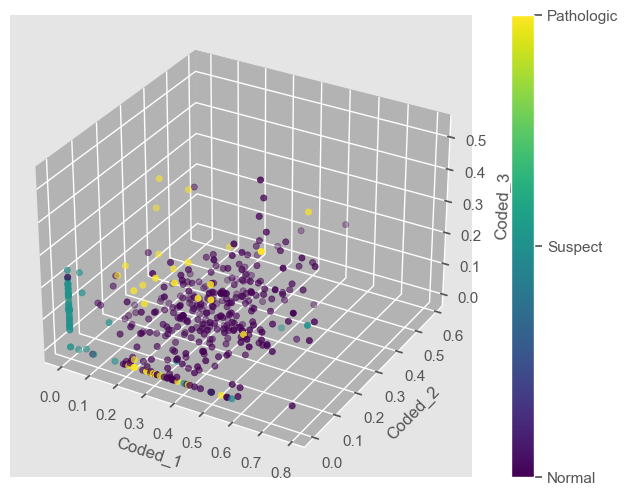

In [12]:
# Visualising the clusters
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style
style.use('ggplot')

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.w_xaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # During the previous visualisation
ax1.w_yaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # the colors were difficult to see
ax1.w_zaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # with the light gray background, color tuning

x3d = encoded_out[:,0]
y3d = encoded_out[:,1]
z3d = encoded_out[:,2]

plot = ax1.scatter(x3d, y3d, z3d, c=y_test_auto, cmap="viridis", marker='o')
ax1.set_xlabel('Coded_1')
ax1.set_ylabel('Coded_2')
ax1.set_zlabel('Coded_3')
cb = plt.colorbar(plot)
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.show()

The results of the dimensionalty reduction using the autoencoder are not as expected but can still provide interesting insights.
We could have expected three different clusters for the three NSP classes, or even ten clusters for the ten fetus classes. Instead we can see around seven clusters. All of them could be understood as their own particular class with different risks for the fetus. 
For example, we find a cluster of suspect cases that is very close to the cluster of pathological cases, they could be interpreted as highly suspect and hence refine or even re-define the classes we used before, would it be for pathological classification or for the fetus classifiaction.
We decided to use the k-means algorithm to efficiently label the groups we found using the autoencoder. We will then insert these new classes in our dataset and study them to see if they can describe the problem in a more efficient way.

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(encoded_out)

C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


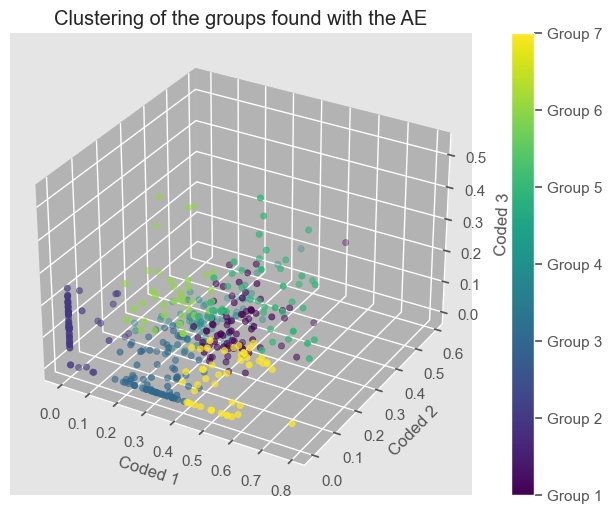

In [14]:
# Visualising the clusters
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style
style.use('ggplot')

fig = plt.figure(figsize=(10,6))
loc = [0,1,2,3,4,5,6]
classes = ['Group 1','Group 2','Group 3','Group 4','Group 5','Group 6','Group 7']
ax1 = fig.add_subplot(111, projection='3d')
ax1.w_xaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # During the previous visualisation
ax1.w_yaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # the colors were difficult to see
ax1.w_zaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # with the light gray background, color tuning

x3d = encoded_out[:,0]
y3d = encoded_out[:,1]
z3d = encoded_out[:,2]

ploto = ax1.scatter(x3d, y3d, z3d, c=y_kmeans, cmap="viridis")
cb = plt.colorbar(ploto)
cb.set_ticks(loc)
cb.set_ticklabels(classes)
ax1.set_xlabel('Coded 1')
ax1.set_ylabel('Coded 2')
ax1.set_zlabel('Coded 3')
plt.title('Clustering of the groups found with the AE')
plt.show()


Now that the new groups have been defined, we will insert them into our dataset and study them the same way we studied the fetus classes given in the dataset. This way we will be able to compare the labelling of the problem and see if the groups found by the autoencoder and by the k-means can represent the problem in a more efficient way.

In [15]:
dataset2 = pd.DataFrame(data=X_test_auto)
dataset2['NSP'] = y_test_auto
dataset2['New Groups'] = y_kmeans
#Succesfully added our new groups to the corresponding dataframe

C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


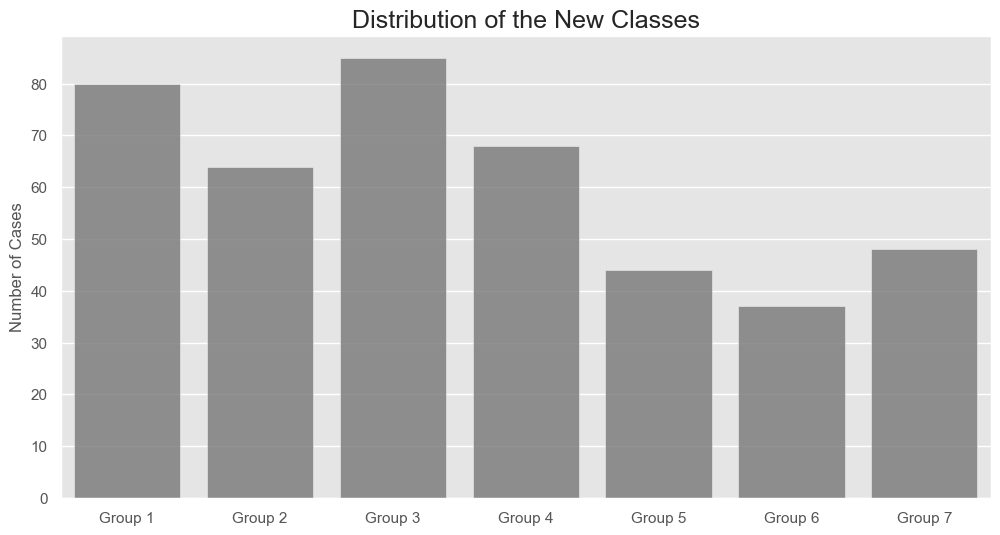

In [16]:
# Distribution of the newfound classes

import matplotlib.cm as cm # To make pretty graphs
import seaborn as sns
color = sns.color_palette()

cnt_srs = dataset2['New Groups'].value_counts()
cnt_srs = cnt_srs.head(10)
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
N = 7
ind = np.arange(N) 
plt.xticks(ind, ('Group 1','Group 2','Group 3','Group 4','Group 5','Group 6','Group 7'))
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Distribution of the New Classes', fontsize=18)
plt.show()

<Figure size 1200x600 with 0 Axes>

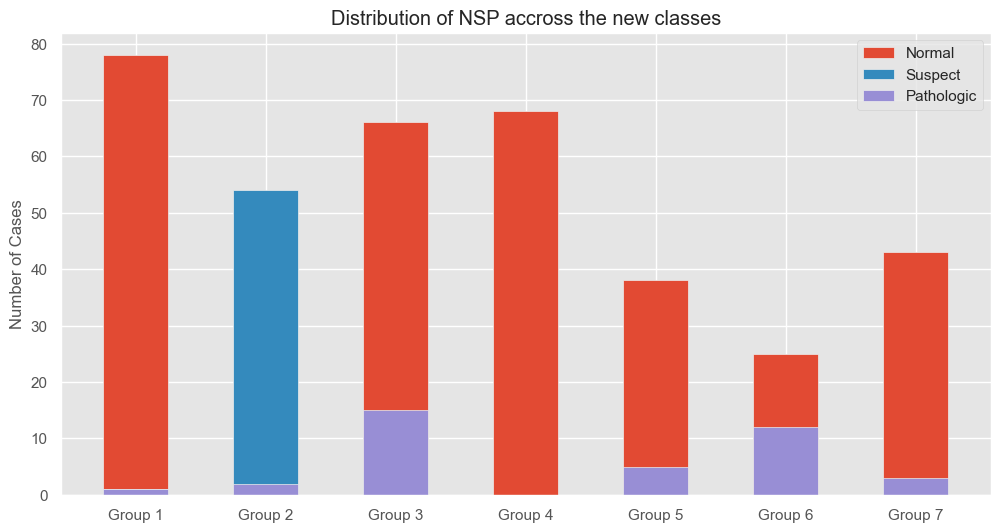

In [17]:
x = dataset2[['New Groups','NSP']]
plt.figure(figsize=(12,6))
N = 7
zeroesddf = pd.DataFrame(data=np.zeros(7,),index=[0,1,2,3,4,5,6])

ind = np.arange(N)    # the x locations for the groups
width = 0.50    # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,6))

for nsp_i in [1,2,3]:
    norm = x.loc[(x['NSP']==nsp_i)].drop('NSP', axis=1)
    norm = (pd.value_counts(norm['New Groups'].values, sort=False)).sort_index()
    norm = pd.DataFrame(data=norm, index=norm.index)
    norm = zeroesddf.add(norm,axis='index',fill_value=0) 
    norm = (norm.values).reshape(-1)
    if nsp_i == 1 :
        p1 = plt.bar(ind,norm, width)
    elif nsp_i == 2 :
        p2 = plt.bar(ind,norm,width)
    elif nsp_i == 3 :
        p3 = plt.bar(ind,norm,width)

plt.ylabel('Number of Cases')wh
plt.title('Distribution of NSP accross the new classes')
plt.xticks(ind, ('Group 1','Group 2','Group 3','Group 4','Group 5','Group 6','Group 7'))
plt.legend((p1[0], p2[0], p3[0]), ('Normal', 'Suspect', 'Pathologic'))
plt.show()

The new groups we previously found while using the autoencoder manage to describe the problem under a new light. While previously our fetus classes were made according to the fetus behavior, these ones have been made with a focus on the possibility of a disease. Much like a BIRADS classification used to describe the risk of breast cancer in a patient, these new classes could allow us to do a statistical risk classification for fetuses.

0 : No risks at all, Group 4

1 : Almost no risks, Group 5 & Group 6

2 : Small risk of pathology, Group3

3 : Verified risk of pathology, Group2

4 : Very high risk of pathology, Group 1

5 : Pathology detected, Group 7

For a more accurate classification we could use a bigger test sample and see how the AE behaves. Could we get more classes ? Less ? A better definition of the previous classes ? What if we tried with a different type of distance for the AE ? Or for the k-means ? We want to keep this simple so we will not explore these possibilities right now, instead, we will keep an eye on the new groups we created while solving the classification problem when it comes to NSP.


**Comparing the AE clusters with the classes given in the dataset**

In [18]:
# Decoding the scaled data
Class_test_auto2 = Class_test_auto

for i in range(426,):
    if Class_test_auto[i]==1. :
        Class_test_auto2[i]=9
    elif Class_test_auto[i]==1/9:
        Class_test_auto2[i]=1
    elif Class_test_auto[i]==2/9:
        Class_test_auto2[i]=2
    elif Class_test_auto[i]==1/3:
        Class_test_auto2[i]=3
    elif Class_test_auto[i]==8/9:
        Class_test_auto2[i]=8
    elif Class_test_auto[i]>0.7 and Class_test_auto[i]<0.8 :
        Class_test_auto2[i]=7
    elif Class_test_auto[i]>0.4 and Class_test_auto[i]<0.5 :
        Class_test_auto2[i]=4
    elif Class_test_auto[i]>0.5 and Class_test_auto[i]<0.6 :
        Class_test_auto2[i]=5
    elif Class_test_auto[i]>0.6 and Class_test_auto[i]<0.7 :
        Class_test_auto2[i]=6

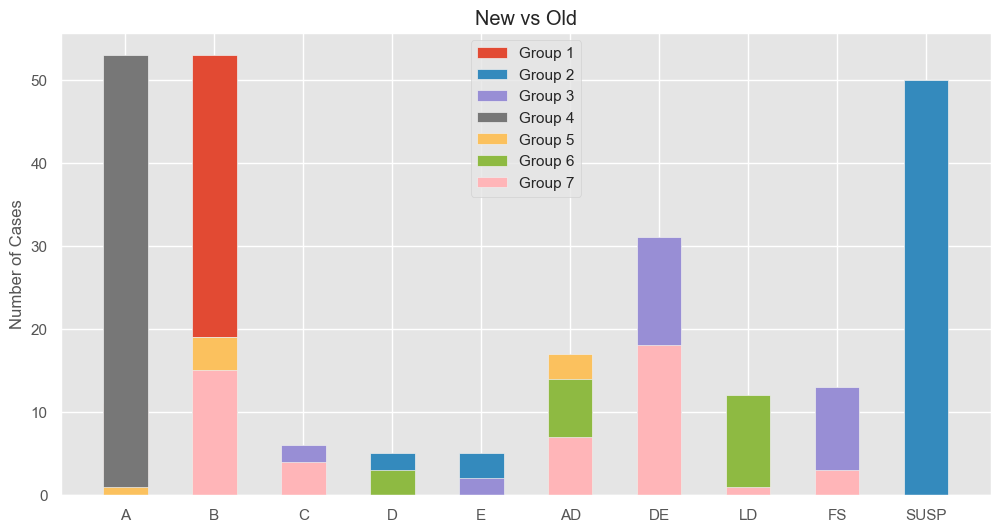

In [19]:
dataset2['CLASS'] = Class_test_auto2

x = dataset2[['CLASS','New Groups']]
N = 10
zeroesddf = pd.DataFrame(data=np.zeros(10,),index=[0,1,2,3,4,5,6,7,8,9])

ind = np.arange(N)    # the x locations for the groups
width = 0.50    # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,6))

norm=[]
p=[]
for class_i in [0,1,2,3,4,5,6]:
    temp = x.loc[(x['New Groups']==class_i)].drop('New Groups', axis=1)
    temp = (pd.value_counts(temp['CLASS'].values, sort=False)).sort_index()
    temp = pd.DataFrame(data=temp, index=temp.index)
    temp = zeroesddf.add(temp,axis='index',fill_value=0) 
    temp = (temp.values).reshape(-1)
    norm.append(temp)
    p_temp = plt.bar(ind,norm[class_i], width)
    p.append(p_temp)
        
plt.ylabel('Number of Cases')
plt.title('New vs Old')
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'))
plt.legend((p[0][0], p[1][0], p[2][0], p[3][0], p[4][0], p[5][0], p[6][0]), ('Group 1', 'Group 2',
                                                               'Group 3','Group 4','Group 5',
                                                              'Group 6','Group 7'))
plt.show()

Overall the clusters we found using the AE behave quite similarly to the ones that were given with the dataset with one little difference. These new clusters focus on a statistical approach of the problem as we explained above. They do not describe entirely the fetus but describe the risk of a pathology. We can see that the main differences are present on the classes that previously presented the most suspect or pathological cases. "SUSP" has been replaced by a hig risk Group 1 that also includes parts of FS. "LD" seems to be entirely interchangeable with Group 7 and shows as we said earlier a verified patholgy in the fetuses. Eventually we realize that the "real" use for such new classes would only be for the last ones that split and refine the result of the suspect and pathological cases.

To conclude on this part, we saw that when the PCA fails to deliver meaningful results, the use of an autoencoder can not only prove efficient in the process of dimensionality reduction, but also can give us some very powerful insights.

**Finding the best classifier**
---
As a first part we're gonna implement an SVC and explain each line and each parameter chosen. In a second part we will test out all the classifiers that can apply to this problem that are in the sklearn library, pick out the best one and tune it to get the best results possible.

**Using an SVC**

The score is : 0.981203007518797


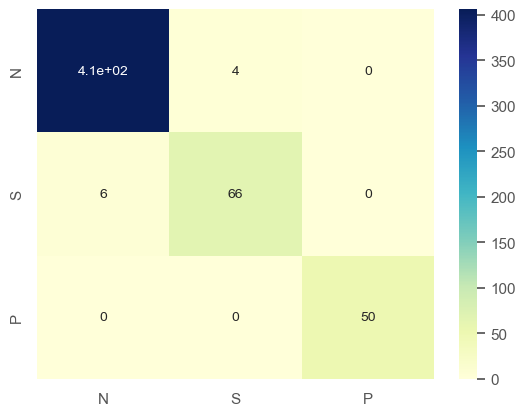

In [20]:
from sklearn.svm import SVC # Importing the relevant classifier
classifier = SVC(kernel = 'linear', random_state = 0) # Choosing a linear Kernel for SVC and not K-svc
classifier.fit(X_train, y_train)# Fitting the classifier onto our dataset
score = classifier.score(X_test, y_test, sample_weight=None) # Checking how well it did

# Predicting the Test set results
y_pred = classifier.predict(X_test) # Still all pretty good

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)

print('The score is : '+str(score))   
label = ["N","S","P"]
sns.heatmap(cm1, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
plt.show()

A score of 98.1%  is fairly high for a non tuned algorithm. It also got a perfect score when it comes to detecting cases classified as pathologic, which is exactly the kind of criteria we're looking for when making a medical classifier.
This score and this confusion matrix will be used in the next part as a comparison point with the other scores and confusion matrixes of other algorithms.

**Testing all the classifiers**

--------------------------------------------------------------------------------
ElasticNet Confusion Matrix


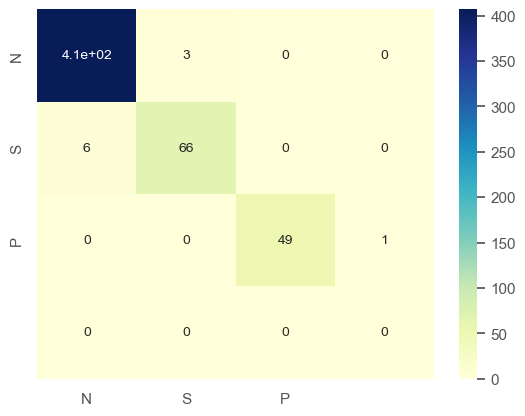

--------------------------------------------------------------------------------
ElasticNet Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.96      0.92      0.94        72
         3.0       1.00      0.98      0.99        50
         4.0       0.00      0.00      0.00         0

    accuracy                           0.98       532
   macro avg       0.74      0.72      0.73       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
ElasticNet Accuracy 98.12 %
--------------------------------------------------------------------------------
SVC Confusion Matrix


C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


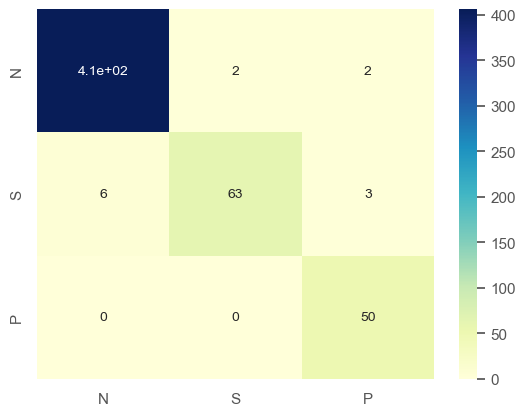

--------------------------------------------------------------------------------
SVC Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.97      0.88      0.92        72
         3.0       0.91      1.00      0.95        50

    accuracy                           0.98       532
   macro avg       0.95      0.96      0.95       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
SVC Accuracy 97.56 %
--------------------------------------------------------------------------------
kSVC Confusion Matrix


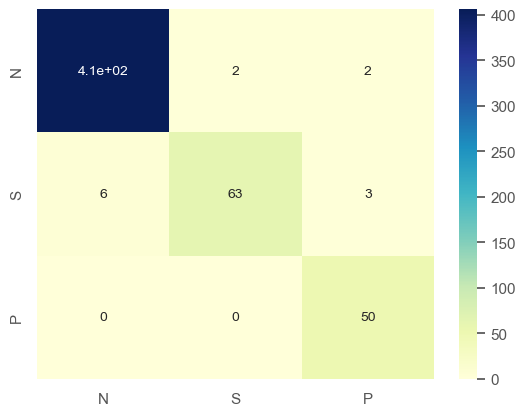

--------------------------------------------------------------------------------
kSVC Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.97      0.88      0.92        72
         3.0       0.91      1.00      0.95        50

    accuracy                           0.98       532
   macro avg       0.95      0.96      0.95       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
kSVC Accuracy 97.56 %
--------------------------------------------------------------------------------
KNN Confusion Matrix


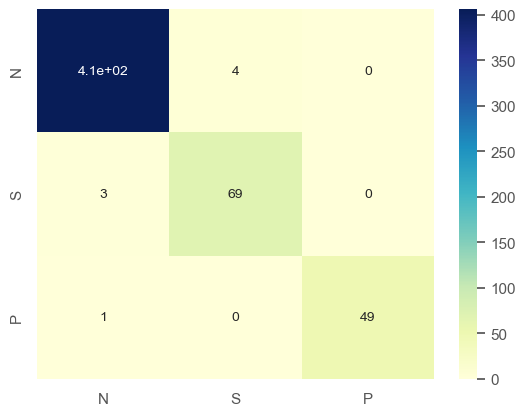

--------------------------------------------------------------------------------
KNN Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.95      0.96      0.95        72
         3.0       1.00      0.98      0.99        50

    accuracy                           0.98       532
   macro avg       0.98      0.98      0.98       532
weighted avg       0.99      0.98      0.98       532

--------------------------------------------------------------------------------
KNN Accuracy 98.5 %
--------------------------------------------------------------------------------
DecisionTree Confusion Matrix


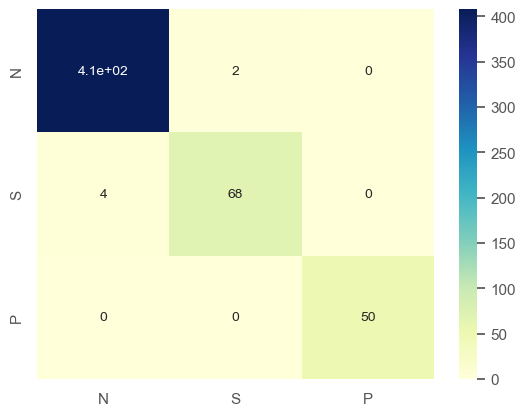

--------------------------------------------------------------------------------
DecisionTree Classification Report
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       410
         2.0       0.97      0.94      0.96        72
         3.0       1.00      1.00      1.00        50

    accuracy                           0.99       532
   macro avg       0.99      0.98      0.98       532
weighted avg       0.99      0.99      0.99       532

--------------------------------------------------------------------------------
DecisionTree Accuracy 98.87 %
--------------------------------------------------------------------------------
RandomForestClassifier Confusion Matrix


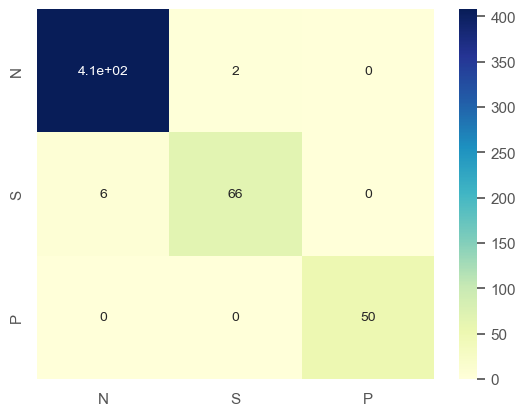

--------------------------------------------------------------------------------
RandomForestClassifier Classification Report
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       410
         2.0       0.97      0.92      0.94        72
         3.0       1.00      1.00      1.00        50

    accuracy                           0.98       532
   macro avg       0.99      0.97      0.98       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
RandomForestClassifier Accuracy 98.5 %
Fitting 5 folds for each of 25 candidates, totalling 125 fits
--------------------------------------------------------------------------------
GridSearchCV Confusion Matrix


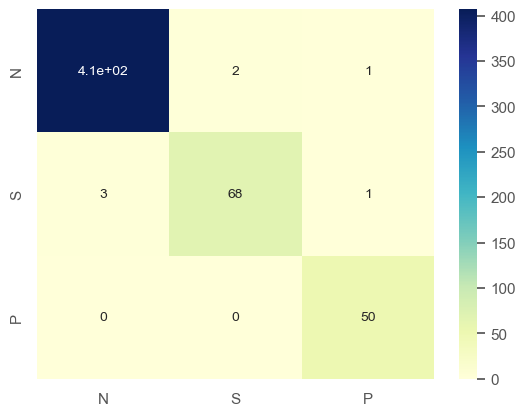

--------------------------------------------------------------------------------
GridSearchCV Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.97      0.94      0.96        72
         3.0       0.96      1.00      0.98        50

    accuracy                           0.99       532
   macro avg       0.98      0.98      0.98       532
weighted avg       0.99      0.99      0.99       532

--------------------------------------------------------------------------------
GridSearchCV Accuracy 98.68 %
--------------------------------------------------------------------------------
HuberRegressor Confusion Matrix


C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


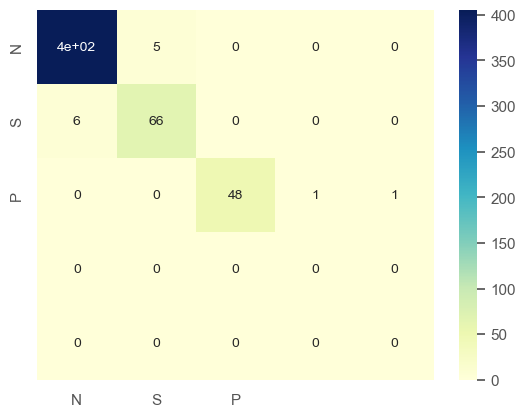

C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------
HuberRegressor Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.93      0.92      0.92        72
         3.0       1.00      0.96      0.98        50
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0

    accuracy                           0.98       532
   macro avg       0.58      0.57      0.58       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
HuberRegressor Accuracy 97.56 %
--------------------------------------------------------------------------------
Lasso Confusion Matrix


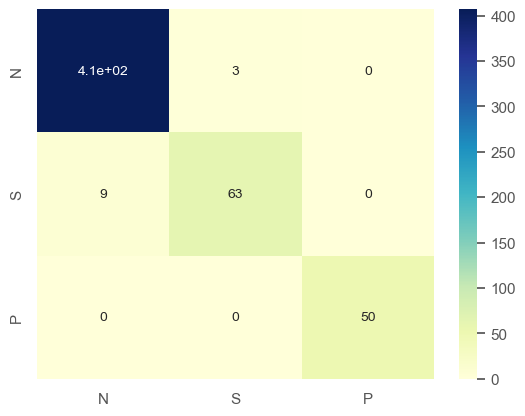

--------------------------------------------------------------------------------
Lasso Classification Report
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       410
         2.0       0.95      0.88      0.91        72
         3.0       1.00      1.00      1.00        50

    accuracy                           0.98       532
   macro avg       0.98      0.96      0.97       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
Lasso Accuracy 97.74 %
--------------------------------------------------------------------------------
LassoCV Confusion Matrix


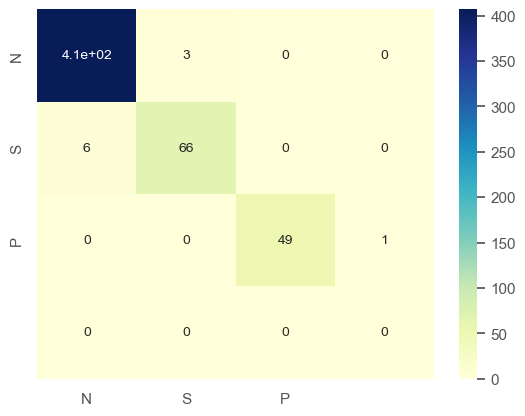

--------------------------------------------------------------------------------
LassoCV Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.96      0.92      0.94        72
         3.0       1.00      0.98      0.99        50
         4.0       0.00      0.00      0.00         0

    accuracy                           0.98       532
   macro avg       0.74      0.72      0.73       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
LassoCV Accuracy 98.12 %
--------------------------------------------------------------------------------
Lars Confusion Matrix


C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_en

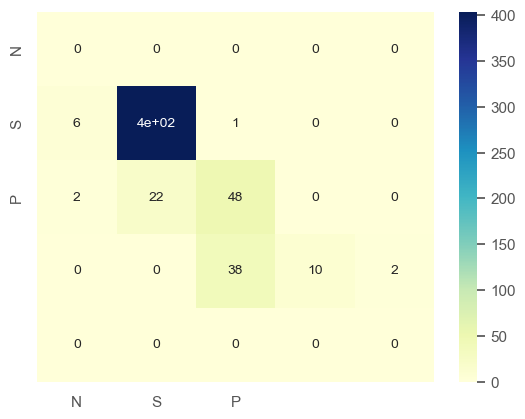

--------------------------------------------------------------------------------
Lars Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.95      0.98      0.97       410
         2.0       0.55      0.67      0.60        72
         3.0       1.00      0.20      0.33        50
         4.0       0.00      0.00      0.00         0

    accuracy                           0.87       532
   macro avg       0.50      0.37      0.38       532
weighted avg       0.90      0.87      0.86       532

--------------------------------------------------------------------------------
Lars Accuracy 86.65 %
--------------------------------------------------------------------------------
BayesianRidge Confusion Matrix


C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


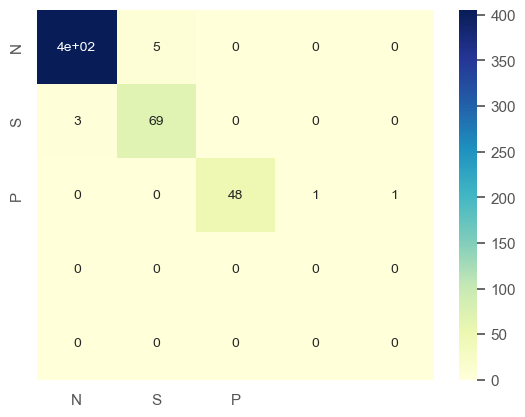

--------------------------------------------------------------------------------
BayesianRidge Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.93      0.96      0.95        72
         3.0       1.00      0.96      0.98        50
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0

    accuracy                           0.98       532
   macro avg       0.59      0.58      0.58       532
weighted avg       0.99      0.98      0.98       532

--------------------------------------------------------------------------------
BayesianRidge Accuracy 98.12 %
--------------------------------------------------------------------------------
SGDClassifier Confusion Matrix


C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prana\miniconda3\envs\ctg_env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


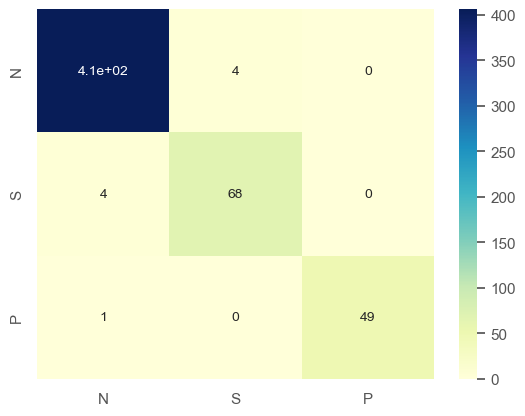

--------------------------------------------------------------------------------
SGDClassifier Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.94      0.94      0.94        72
         3.0       1.00      0.98      0.99        50

    accuracy                           0.98       532
   macro avg       0.98      0.97      0.97       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
SGDClassifier Accuracy 98.31 %
--------------------------------------------------------------------------------
RidgeClassifier Confusion Matrix


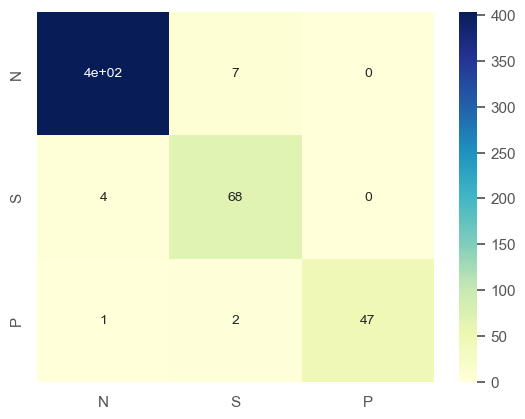

--------------------------------------------------------------------------------
RidgeClassifier Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       410
         2.0       0.88      0.94      0.91        72
         3.0       1.00      0.94      0.97        50

    accuracy                           0.97       532
   macro avg       0.96      0.96      0.96       532
weighted avg       0.97      0.97      0.97       532

--------------------------------------------------------------------------------
RidgeClassifier Accuracy 97.37 %


In [21]:
# Importing all the classifiers fitting to the problem from sklearn                             
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Setting different parameters for the grid search
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

# Turning our problem into a non linear problem
n_col=36
poly = PolynomialFeatures(2)
X_train=poly.fit_transform(X_train)
X_test=poly.fit_transform(X_test)



names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         #♠'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    #Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True), # Seem to have problems with the Ridge, so I'm taking it out
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

models=zip(names,classifiers,correction)
   
for name, clf,correct in models:
    regr=clf.fit(X_train,y_train)
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
    
    # Confusion Matrix
    print('--'*40)
    print(name, 'Confusion Matrix')
    conf=confusion_matrix(y_test, np.round(regr.predict(X_test) ) )     
    label = ["N","S","P"]
    sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
    plt.show()
    
    print('--'*40)

    # Classification Report
    print(name,'Classification Report')
    classif=classification_report(y_test,np.round( regr.predict(X_test) ) )
    print(classif)


    # Accuracy
    print('--'*40)
    logreg_accuracy = round(accuracy_score(y_test, np.round( regr.predict(X_test) ) ) * 100,2)
    print(name, 'Accuracy', logreg_accuracy,'%')

After this multi-model study, some of the algorithms we have used stand out with an accuracy equal or beyond 98.5%. These algorithms are : KNN, Decision Tree, Random Forest, GridSearchCV ( applied to kSVC) , SGDC. Amongst these, the one to particularly stand out is the kSVC after it has been optimized by the grid search, quite obviously. We want to know if we can push the limits of this algorithms to even higher accuracies and scores. The method used here could be used for any of the above algorithms, while testing for the algorithm-specific parameters.

**Optimization of the kSVC**
This one can take a few minutes to run, if you don't want to run it you can see the results right below the code.

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

# Here we typed out all the options we want the method to test, each one in
# its own dictionary.

from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(),param_grid = parameters, refit = True, verbose = 1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
0.9868279410894896
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


After this grid search we obtained an accuracy of 98.80% with the parameters set as such : C=100, gamma=1e-4, kernel=rbf.
Let's try to push it even more.

In [23]:
parameters = {'C': [50,75, 125, 100, 500], 'gamma': [0.0001,0.00001], 'kernel': ['rbf']}

from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(),param_grid = parameters, refit = True, verbose = 1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.9874549003371385
{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}


Not a significant increase in the accuracy this time. We got 98.93% accuracy with the parameters set as such : C=500, gamma=1e-5, kernel=rbf.
To this point, trying to get the algorithm past our current accuracy would be a waste of our time.


Maybe an Artificial Neural Network could do better ?

**Using an Artificial Neural Network as a classifier**
---
Using the Keras library, we will build a simple ANN ( artificial neural network ). It will be composed of 4 layers. One input, one output, and two hidden layers. For this classification to happen in an ANN we will also have to encode categorical data ( our NSP classes ) in numerical data. After being processed by the ANN we will decode the predicted results to compare them with the actual results in the form of a confusion matrix.

In [24]:
# Importing the Keras libraries, models and layers
import keras
from keras.models import Sequential
from keras.layers import Dense

In [25]:
# In this part we are barely reprocessing the data and putting it in a form that will fit the ANN
# as we explained earlier.

# While chain-testing the different algorithms we had changed X and y to fit a polynomial form,
# so we have to import them anew.
X = dataset.iloc[:,:-2].values
y = dataset.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_trainann = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_trainann = np.delete(y_trainann, 1, 1) # Deleting a column to avoid redundancy after the OHE

In [28]:
# Initializing the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(20, kernel_initializer = 'uniform', activation = 'relu', input_shape = (36, )))

# Adding the second hidden layer
classifier.add(Dense(20, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(2, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_trainann, batch_size = 5, epochs = 20)


Epoch 1/20
319/319 [==============================] - 0s 729us/step - loss: 0.3430 - accuracy: 0.8833
Epoch 2/20
319/319 [==============================] - 0s 733us/step - loss: 2.6273 - accuracy: 0.8049
Epoch 3/20
319/319 [==============================] - 0s 748us/step - loss: 6.7138 - accuracy: 0.7961
Epoch 4/20
319/319 [==============================] - 0s 749us/step - loss: 14.5792 - accuracy: 0.7880
Epoch 5/20
319/319 [==============================] - 0s 747us/step - loss: 24.1797 - accuracy: 0.7886
Epoch 6/20
319/319 [==============================] - 0s 746us/step - loss: 24.2381 - accuracy: 0.7967
Epoch 7/20
319/319 [==============================] - 0s 748us/step - loss: 42.5253 - accuracy: 0.7930
Epoch 8/20
319/319 [==============================] - 0s 753us/step - loss: 44.7800 - accuracy: 0.8036
Epoch 9/20
319/319 [==============================] - 0s 744us/step - loss: 57.8920 - accuracy: 0.7917
Epoch 10/20
319/319 [==============================] - 0s 745us/step - loss:

With a very simple ANN and no tuning whatsoever we got accuracies around 97% at the end of training.
Let's decode the results and create the confusion matrix to get the actual score.

17/17 [==============================] - 0s 689us/step
The score is : 0.13533834586466165


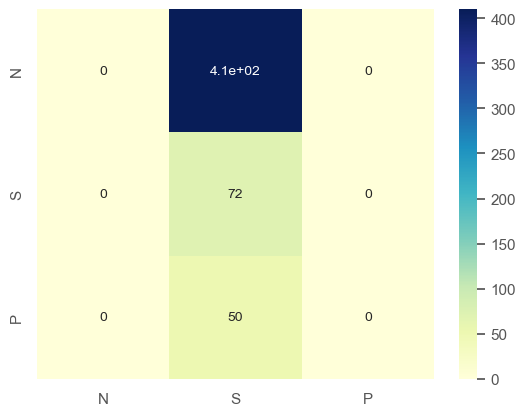

In [29]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.7)

recovered_y = np.zeros(532,)
for i in range(0,532):
    for j in range(0,2):
        if (y_pred[i][j] == True) and j == 0:
            recovered_y[i] = 1
        elif (y_pred[i][j] == True) and j == 1:
            recovered_y[i] = 3            
for i in range(0,532):
    if recovered_y[i] == 0:
        recovered_y[i] = 2
     
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, recovered_y)
acc = accuracy_score(y_test, recovered_y)

print('The score is : '+str(acc))   
label = ["N","S","P"]
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
plt.show()

Not a very good result... It seems like the high accuracy during training and the sudden drop we get would be a symptom of overfitting, we can try with less epochs and different batch sizes. In order to do this we will create a for loop that will work in tha same manner as a grid search for our parameters ( here they are the number of epochs and the batch size ).

The number of epochs is : 5
The batch size is : 1
Epoch 1/5
1594/1594 [==============================] - 1s 796us/step - loss: 589.0715 - accuracy: 0.7992
Epoch 2/5
1594/1594 [==============================] - 1s 844us/step - loss: 565.2370 - accuracy: 0.8030
Epoch 3/5
1594/1594 [==============================] - 1s 805us/step - loss: 530.4556 - accuracy: 0.8024
Epoch 4/5
1594/1594 [==============================] - 1s 801us/step - loss: 704.7454 - accuracy: 0.8011
Epoch 5/5
17/17 [==============================] - 0s 720us/step
The accuracy is : 0.13533834586466165


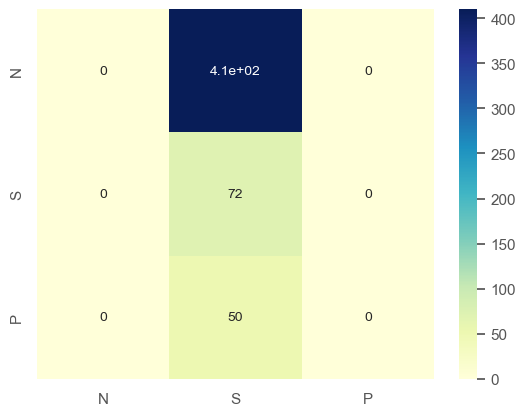

The number of epochs is : 5
The batch size is : 2
Epoch 1/5
797/797 [==============================] - 1s 836us/step - loss: 728.1957 - accuracy: 0.7905
Epoch 2/5
797/797 [==============================] - 1s 886us/step - loss: 656.3764 - accuracy: 0.8055
Epoch 3/5
797/797 [==============================] - 1s 914us/step - loss: 837.3167 - accuracy: 0.8030
Epoch 4/5
797/797 [==============================] - 1s 874us/step - loss: 844.9912 - accuracy: 0.8030
Epoch 5/5
17/17 [==============================] - 0s 813us/step
The accuracy is : 0.13533834586466165


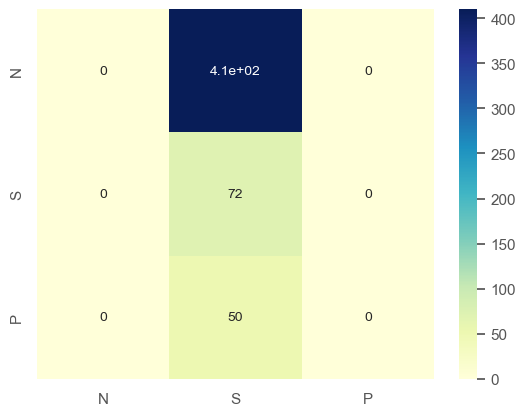

The number of epochs is : 5
The batch size is : 3
Epoch 1/5
532/532 [==============================] - 0s 789us/step - loss: 838.1819 - accuracy: 0.7917
Epoch 2/5
532/532 [==============================] - 0s 842us/step - loss: 1112.8055 - accuracy: 0.7898
Epoch 3/5
532/532 [==============================] - 0s 834us/step - loss: 929.5809 - accuracy: 0.8005
Epoch 4/5
532/532 [==============================] - 0s 751us/step - loss: 1108.2911 - accuracy: 0.7980
Epoch 5/5
17/17 [==============================] - 0s 801us/step
The accuracy is : 0.13533834586466165


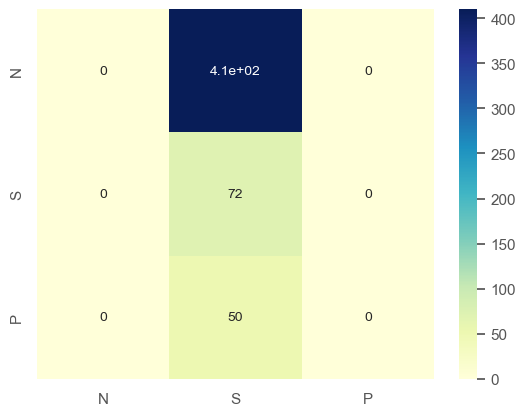

The number of epochs is : 5
The batch size is : 4
Epoch 1/5
399/399 [==============================] - 0s 767us/step - loss: 1186.1982 - accuracy: 0.7892
Epoch 2/5
399/399 [==============================] - 0s 764us/step - loss: 1107.4404 - accuracy: 0.8043
Epoch 3/5
399/399 [==============================] - 0s 814us/step - loss: 1282.9821 - accuracy: 0.8030
Epoch 4/5
399/399 [==============================] - 0s 949us/step - loss: 1298.2196 - accuracy: 0.7930
Epoch 5/5
17/17 [==============================] - 0s 774us/step
The accuracy is : 0.13533834586466165


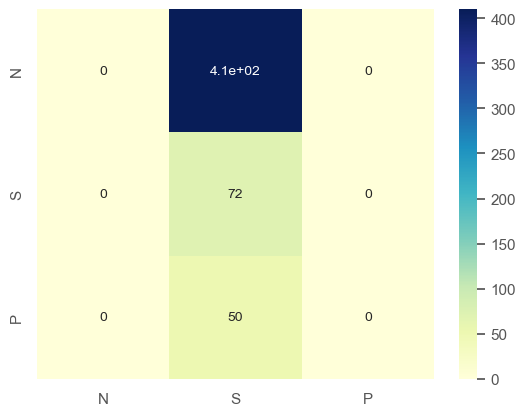

The number of epochs is : 5
The batch size is : 5
Epoch 1/5
319/319 [==============================] - 0s 924us/step - loss: 1301.4940 - accuracy: 0.8011
Epoch 2/5
319/319 [==============================] - 0s 771us/step - loss: 1811.6299 - accuracy: 0.7942
Epoch 3/5
319/319 [==============================] - 0s 820us/step - loss: 1171.5634 - accuracy: 0.7986
Epoch 4/5
319/319 [==============================] - 0s 860us/step - loss: 1423.1067 - accuracy: 0.7905
Epoch 5/5
17/17 [==============================] - 0s 738us/step
The accuracy is : 0.13533834586466165


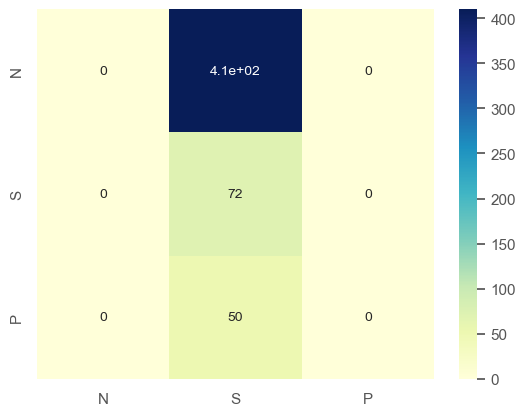

The number of epochs is : 5
The batch size is : 10
Epoch 1/5
160/160 [==============================] - 0s 899us/step - loss: 1001.9172 - accuracy: 0.7917
Epoch 2/5
160/160 [==============================] - 0s 882us/step - loss: 1073.2045 - accuracy: 0.8055
Epoch 3/5
160/160 [==============================] - 0s 795us/step - loss: 974.4769 - accuracy: 0.7930
Epoch 4/5
160/160 [==============================] - 0s 832us/step - loss: 1775.2372 - accuracy: 0.7942
Epoch 5/5
17/17 [==============================] - 0s 742us/step
The accuracy is : 0.13533834586466165


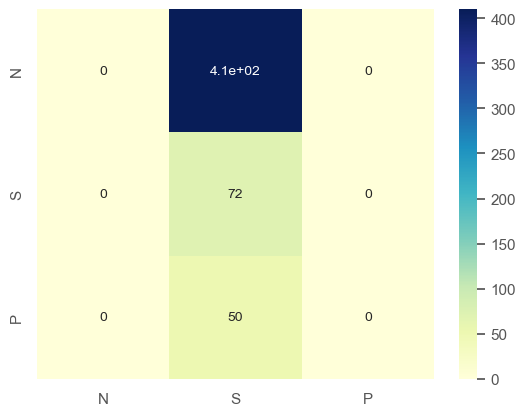

The number of epochs is : 5
The batch size is : 15
Epoch 1/5
107/107 [==============================] - 0s 921us/step - loss: 1354.7164 - accuracy: 0.7905
Epoch 2/5
107/107 [==============================] - 0s 897us/step - loss: 1069.9624 - accuracy: 0.8024
Epoch 3/5
107/107 [==============================] - 0s 913us/step - loss: 1304.2510 - accuracy: 0.8011
Epoch 4/5
107/107 [==============================] - 0s 923us/step - loss: 1291.1067 - accuracy: 0.7886
Epoch 5/5
17/17 [==============================] - 0s 802us/step
The accuracy is : 0.13533834586466165


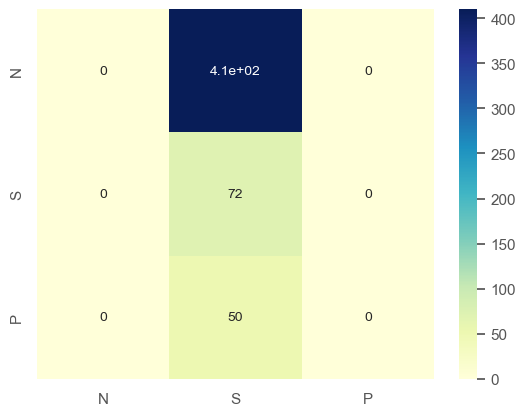

The number of epochs is : 5
The batch size is : 20
Epoch 1/5
80/80 [==============================] - 0s 947us/step - loss: 1706.7955 - accuracy: 0.8005
Epoch 2/5
80/80 [==============================] - 0s 964us/step - loss: 1279.5885 - accuracy: 0.8030
Epoch 3/5
80/80 [==============================] - 0s 951us/step - loss: 803.1418 - accuracy: 0.7967
Epoch 4/5
80/80 [==============================] - 0s 974us/step - loss: 891.5483 - accuracy: 0.7880
Epoch 5/5
17/17 [==============================] - 0s 750us/step
The accuracy is : 0.13533834586466165


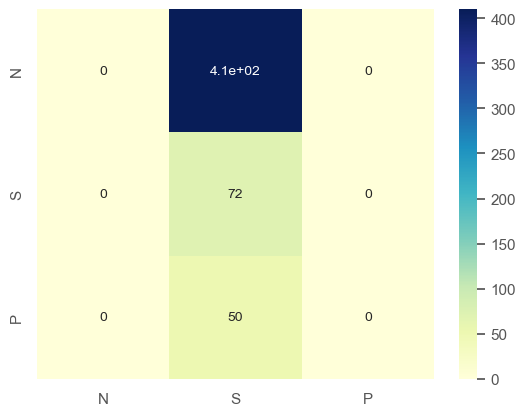

The number of epochs is : 10
The batch size is : 1
Epoch 1/10
1594/1594 [==============================] - 1s 842us/step - loss: 3044.4321 - accuracy: 0.7949
Epoch 2/10
1594/1594 [==============================] - 1s 842us/step - loss: 3126.5295 - accuracy: 0.7992
Epoch 3/10
1594/1594 [==============================] - 1s 823us/step - loss: 3316.3765 - accuracy: 0.7955
Epoch 4/10
1594/1594 [==============================] - 1s 843us/step - loss: 3348.0603 - accuracy: 0.8011
Epoch 5/10
1594/1594 [==============================] - 1s 826us/step - loss: 3683.1323 - accuracy: 0.7986
Epoch 6/10
1594/1594 [==============================] - 1s 831us/step - loss: 4201.4556 - accuracy: 0.8005
Epoch 7/10
1594/1594 [==============================] - 1s 818us/step - loss: 4156.3062 - accuracy: 0.8024
Epoch 8/10
1594/1594 [==============================] - 1s 819us/step - loss: 4029.8921 - accuracy: 0.8030
Epoch 9/10
1594/1594 [==============================] - 1s 810us/step - loss: 4160.2510 - acc

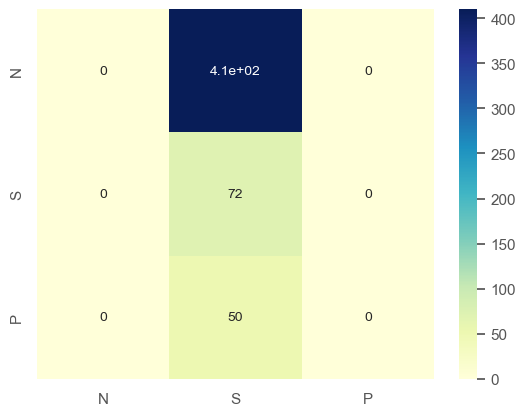

The number of epochs is : 10
The batch size is : 2
Epoch 1/10
797/797 [==============================] - 1s 832us/step - loss: 3886.1230 - accuracy: 0.8030
Epoch 2/10
797/797 [==============================] - 1s 838us/step - loss: 3312.9736 - accuracy: 0.8055
Epoch 3/10
797/797 [==============================] - 1s 834us/step - loss: 3443.3933 - accuracy: 0.7992
Epoch 4/10
797/797 [==============================] - 1s 838us/step - loss: 4198.5645 - accuracy: 0.7980
Epoch 5/10
797/797 [==============================] - 1s 866us/step - loss: 5367.6489 - accuracy: 0.7905
Epoch 6/10
797/797 [==============================] - 1s 976us/step - loss: 3673.3357 - accuracy: 0.8061
Epoch 7/10
797/797 [==============================] - 1s 852us/step - loss: 5101.8521 - accuracy: 0.7949
Epoch 8/10
797/797 [==============================] - 1s 855us/step - loss: 3641.8169 - accuracy: 0.8018
Epoch 9/10
797/797 [==============================] - 1s 850us/step - loss: 5125.4805 - accuracy: 0.7917
Epoc

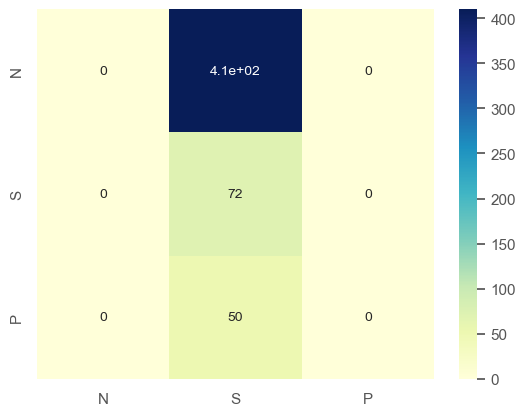

The number of epochs is : 10
The batch size is : 3
Epoch 1/10
532/532 [==============================] - 0s 759us/step - loss: 5314.6699 - accuracy: 0.7980
Epoch 2/10
532/532 [==============================] - 0s 753us/step - loss: 4660.8784 - accuracy: 0.7961
Epoch 3/10
532/532 [==============================] - 0s 756us/step - loss: 4115.9546 - accuracy: 0.8011
Epoch 4/10
532/532 [==============================] - 0s 751us/step - loss: 4606.3135 - accuracy: 0.7961
Epoch 5/10
532/532 [==============================] - 0s 756us/step - loss: 5302.5244 - accuracy: 0.7917
Epoch 6/10
532/532 [==============================] - 0s 753us/step - loss: 4716.2461 - accuracy: 0.7936
Epoch 7/10
532/532 [==============================] - 0s 753us/step - loss: 5717.0000 - accuracy: 0.7911
Epoch 8/10
532/532 [==============================] - 0s 755us/step - loss: 6010.3989 - accuracy: 0.7980
Epoch 9/10
532/532 [==============================] - 0s 755us/step - loss: 5320.7129 - accuracy: 0.7930
Epoc

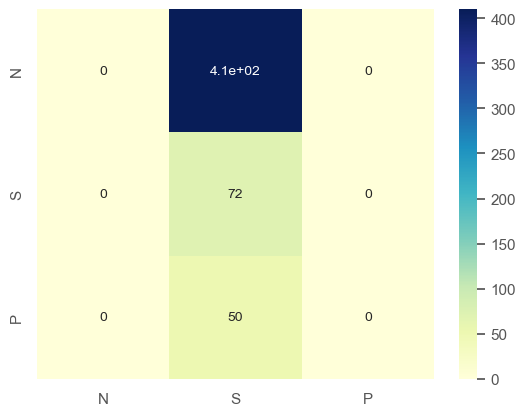

The number of epochs is : 10
The batch size is : 4
Epoch 1/10
399/399 [==============================] - 0s 765us/step - loss: 5309.4302 - accuracy: 0.7905
Epoch 2/10
399/399 [==============================] - 0s 755us/step - loss: 4561.9282 - accuracy: 0.7892
Epoch 3/10
399/399 [==============================] - 0s 755us/step - loss: 5834.0791 - accuracy: 0.7942
Epoch 4/10
399/399 [==============================] - 0s 754us/step - loss: 5160.2310 - accuracy: 0.8018
Epoch 5/10
399/399 [==============================] - 0s 756us/step - loss: 5784.2510 - accuracy: 0.7992
Epoch 6/10
399/399 [==============================] - 0s 764us/step - loss: 5516.5293 - accuracy: 0.7892
Epoch 7/10
399/399 [==============================] - 0s 755us/step - loss: 5264.7026 - accuracy: 0.7986
Epoch 8/10
399/399 [==============================] - 0s 758us/step - loss: 7729.7866 - accuracy: 0.7942
Epoch 9/10
399/399 [==============================] - 0s 759us/step - loss: 6926.7354 - accuracy: 0.7923
Epoc

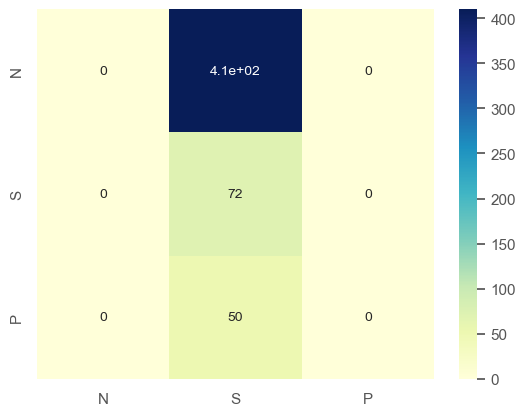

The number of epochs is : 10
The batch size is : 5
Epoch 1/10
319/319 [==============================] - 0s 762us/step - loss: 6054.7051 - accuracy: 0.7992
Epoch 2/10
319/319 [==============================] - 0s 760us/step - loss: 7727.4189 - accuracy: 0.7999
Epoch 3/10
319/319 [==============================] - 0s 764us/step - loss: 9900.8076 - accuracy: 0.7923
Epoch 4/10
319/319 [==============================] - 0s 760us/step - loss: 6810.3394 - accuracy: 0.7905
Epoch 5/10
319/319 [==============================] - 0s 757us/step - loss: 6326.9663 - accuracy: 0.7848
Epoch 6/10
319/319 [==============================] - 0s 762us/step - loss: 4857.9775 - accuracy: 0.8055
Epoch 7/10
319/319 [==============================] - 0s 756us/step - loss: 5282.7705 - accuracy: 0.7967
Epoch 8/10
319/319 [==============================] - 0s 759us/step - loss: 6541.8130 - accuracy: 0.7905
Epoch 9/10
319/319 [==============================] - 0s 759us/step - loss: 7982.7354 - accuracy: 0.7986
Epoc

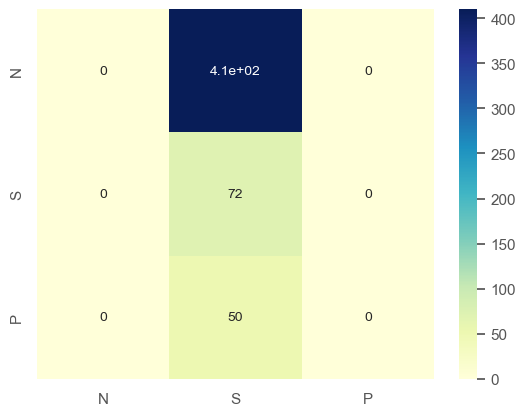

The number of epochs is : 10
The batch size is : 10
Epoch 1/10
160/160 [==============================] - 0s 820us/step - loss: 5916.7075 - accuracy: 0.7955
Epoch 2/10
160/160 [==============================] - 0s 772us/step - loss: 4492.6875 - accuracy: 0.7967
Epoch 3/10
160/160 [==============================] - 0s 767us/step - loss: 5359.8193 - accuracy: 0.8018
Epoch 4/10
160/160 [==============================] - 0s 762us/step - loss: 4243.6748 - accuracy: 0.7992
Epoch 5/10
160/160 [==============================] - 0s 766us/step - loss: 7586.4893 - accuracy: 0.7955
Epoch 6/10
160/160 [==============================] - 0s 782us/step - loss: 5177.2949 - accuracy: 0.8030
Epoch 7/10
160/160 [==============================] - 0s 779us/step - loss: 8966.3838 - accuracy: 0.7955
Epoch 8/10
160/160 [==============================] - 0s 776us/step - loss: 6604.5293 - accuracy: 0.7936
Epoch 9/10
160/160 [==============================] - 0s 769us/step - loss: 4637.9155 - accuracy: 0.8055
Epo

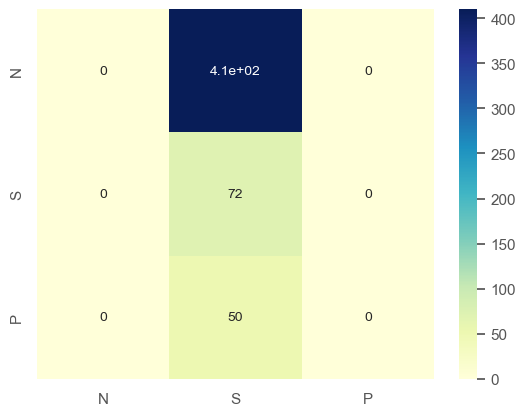

The number of epochs is : 10
The batch size is : 15
Epoch 1/10
107/107 [==============================] - 0s 786us/step - loss: 5863.6299 - accuracy: 0.7999
Epoch 2/10
107/107 [==============================] - 0s 783us/step - loss: 7729.4258 - accuracy: 0.7880
Epoch 3/10
107/107 [==============================] - 0s 777us/step - loss: 4819.4731 - accuracy: 0.8018
Epoch 4/10
107/107 [==============================] - 0s 779us/step - loss: 3634.6699 - accuracy: 0.7848
Epoch 5/10
107/107 [==============================] - 0s 778us/step - loss: 8023.4893 - accuracy: 0.7999
Epoch 6/10
107/107 [==============================] - 0s 777us/step - loss: 8710.9473 - accuracy: 0.8030
Epoch 7/10
107/107 [==============================] - 0s 786us/step - loss: 8625.9473 - accuracy: 0.7980
Epoch 8/10
107/107 [==============================] - 0s 774us/step - loss: 9012.3564 - accuracy: 0.7848
Epoch 9/10
107/107 [==============================] - 0s 785us/step - loss: 6293.0835 - accuracy: 0.8018
Epo

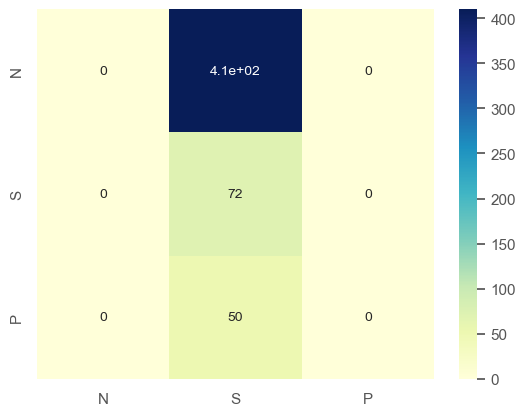

The number of epochs is : 10
The batch size is : 20
Epoch 1/10
80/80 [==============================] - 0s 819us/step - loss: 8869.8623 - accuracy: 0.8093
Epoch 2/10
80/80 [==============================] - 0s 802us/step - loss: 8917.5205 - accuracy: 0.7829
Epoch 3/10
80/80 [==============================] - 0s 787us/step - loss: 5012.2759 - accuracy: 0.8005
Epoch 4/10
80/80 [==============================] - 0s 793us/step - loss: 7402.5996 - accuracy: 0.7880
Epoch 5/10
80/80 [==============================] - 0s 790us/step - loss: 8575.7207 - accuracy: 0.7955
Epoch 6/10
80/80 [==============================] - 0s 799us/step - loss: 5907.4331 - accuracy: 0.7980
Epoch 7/10
80/80 [==============================] - 0s 794us/step - loss: 6005.2397 - accuracy: 0.7967
Epoch 8/10
80/80 [==============================] - 0s 773us/step - loss: 7855.2974 - accuracy: 0.7967
Epoch 9/10
80/80 [==============================] - 0s 785us/step - loss: 13733.9424 - accuracy: 0.8105
Epoch 10/10
17/17 [=

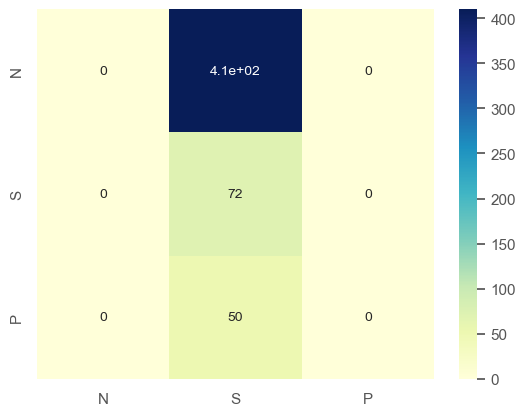

The number of epochs is : 15
The batch size is : 1
Epoch 1/15
1594/1594 [==============================] - 1s 807us/step - loss: 16867.2129 - accuracy: 0.7961
Epoch 2/15
1594/1594 [==============================] - 1s 837us/step - loss: 15969.8467 - accuracy: 0.7923
Epoch 3/15
1594/1594 [==============================] - 1s 804us/step - loss: 16656.7832 - accuracy: 0.7930
Epoch 4/15
1594/1594 [==============================] - 1s 805us/step - loss: 13686.4443 - accuracy: 0.8005
Epoch 5/15
1594/1594 [==============================] - 1s 806us/step - loss: 15474.4287 - accuracy: 0.7980
Epoch 6/15
1594/1594 [==============================] - 1s 808us/step - loss: 16555.7637 - accuracy: 0.8043
Epoch 7/15
1594/1594 [==============================] - 1s 814us/step - loss: 16012.0449 - accuracy: 0.7980
Epoch 8/15
1594/1594 [==============================] - 1s 809us/step - loss: 18268.7480 - accuracy: 0.8005
Epoch 9/15
1594/1594 [==============================] - 1s 811us/step - loss: 19108.1

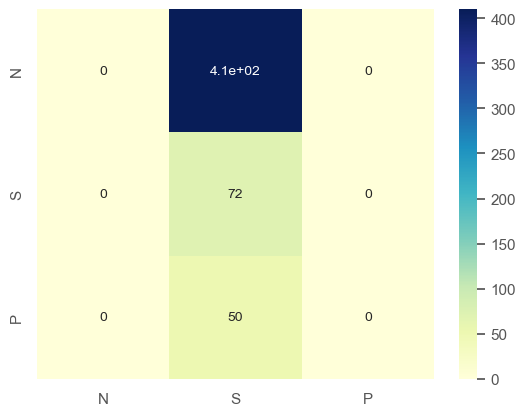

The number of epochs is : 15
The batch size is : 2
Epoch 1/15
797/797 [==============================] - 1s 838us/step - loss: 13205.2021 - accuracy: 0.7936
Epoch 2/15
797/797 [==============================] - 1s 837us/step - loss: 15715.7344 - accuracy: 0.8043
Epoch 3/15
797/797 [==============================] - 1s 843us/step - loss: 16603.2227 - accuracy: 0.8018
Epoch 4/15
797/797 [==============================] - 1s 837us/step - loss: 17921.3672 - accuracy: 0.8068
Epoch 5/15
797/797 [==============================] - 1s 842us/step - loss: 14887.1865 - accuracy: 0.7992
Epoch 6/15
797/797 [==============================] - 1s 834us/step - loss: 12519.3496 - accuracy: 0.7980
Epoch 7/15
797/797 [==============================] - 1s 835us/step - loss: 20200.8730 - accuracy: 0.8049
Epoch 8/15
797/797 [==============================] - 1s 839us/step - loss: 14581.2393 - accuracy: 0.8156
Epoch 9/15
797/797 [==============================] - 1s 838us/step - loss: 22040.5723 - accuracy: 0.

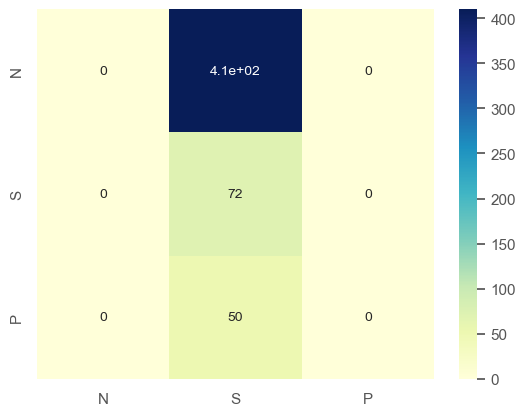

The number of epochs is : 15
The batch size is : 3
Epoch 1/15
532/532 [==============================] - 0s 761us/step - loss: 15439.4980 - accuracy: 0.8055
Epoch 2/15
532/532 [==============================] - 0s 755us/step - loss: 13412.5371 - accuracy: 0.7936
Epoch 3/15
532/532 [==============================] - 0s 754us/step - loss: 19581.4297 - accuracy: 0.7930
Epoch 4/15
532/532 [==============================] - 0s 753us/step - loss: 15897.8574 - accuracy: 0.7999
Epoch 5/15
532/532 [==============================] - 0s 753us/step - loss: 17521.8672 - accuracy: 0.7867
Epoch 6/15
532/532 [==============================] - 0s 761us/step - loss: 21554.1074 - accuracy: 0.7967
Epoch 7/15
532/532 [==============================] - 0s 755us/step - loss: 18671.7812 - accuracy: 0.7992
Epoch 8/15
532/532 [==============================] - 0s 754us/step - loss: 17778.9941 - accuracy: 0.7936
Epoch 9/15
532/532 [==============================] - 0s 758us/step - loss: 17984.4023 - accuracy: 0.

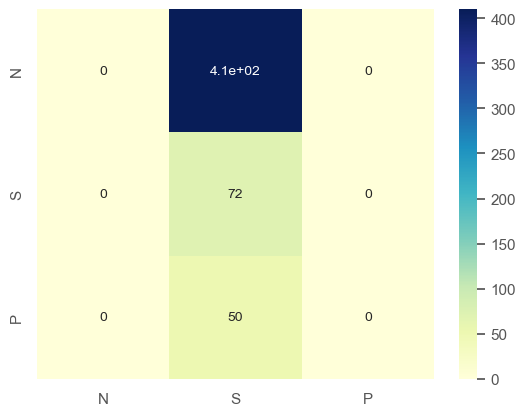

The number of epochs is : 15
The batch size is : 4
Epoch 1/15
399/399 [==============================] - 0s 887us/step - loss: 16605.6328 - accuracy: 0.7967
Epoch 2/15
399/399 [==============================] - 0s 904us/step - loss: 13761.5254 - accuracy: 0.8105
Epoch 3/15
399/399 [==============================] - 0s 872us/step - loss: 20006.8652 - accuracy: 0.8043
Epoch 4/15
399/399 [==============================] - 0s 883us/step - loss: 17721.6562 - accuracy: 0.7980
Epoch 5/15
399/399 [==============================] - 0s 859us/step - loss: 18834.7910 - accuracy: 0.7892
Epoch 6/15
399/399 [==============================] - 0s 791us/step - loss: 14995.2725 - accuracy: 0.7992
Epoch 7/15
399/399 [==============================] - 0s 834us/step - loss: 19533.4102 - accuracy: 0.7980
Epoch 8/15
399/399 [==============================] - 0s 766us/step - loss: 18410.4824 - accuracy: 0.8061
Epoch 9/15
399/399 [==============================] - 0s 871us/step - loss: 17237.4395 - accuracy: 0.

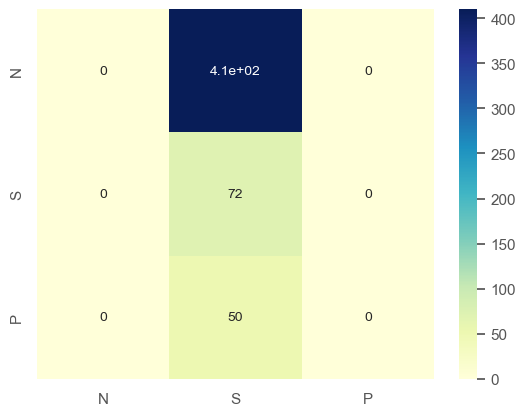

The number of epochs is : 15
The batch size is : 5
Epoch 1/15
319/319 [==============================] - 0s 803us/step - loss: 19132.8691 - accuracy: 0.7992
Epoch 2/15
319/319 [==============================] - 0s 789us/step - loss: 19625.7559 - accuracy: 0.7936
Epoch 3/15
319/319 [==============================] - 0s 783us/step - loss: 15398.5459 - accuracy: 0.7905
Epoch 4/15
319/319 [==============================] - 0s 775us/step - loss: 18579.5938 - accuracy: 0.7898
Epoch 5/15
319/319 [==============================] - 0s 772us/step - loss: 25256.6328 - accuracy: 0.7961
Epoch 6/15
319/319 [==============================] - 0s 783us/step - loss: 18171.5039 - accuracy: 0.8036
Epoch 7/15
319/319 [==============================] - 0s 870us/step - loss: 21124.9785 - accuracy: 0.7949
Epoch 8/15
319/319 [==============================] - 0s 773us/step - loss: 18101.1602 - accuracy: 0.7961
Epoch 9/15
319/319 [==============================] - 0s 775us/step - loss: 22820.6172 - accuracy: 0.

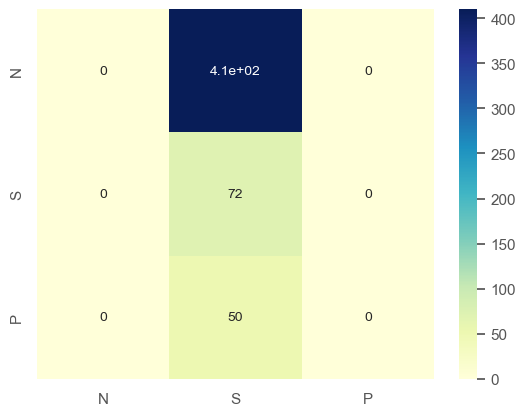

The number of epochs is : 15
The batch size is : 10
Epoch 1/15
160/160 [==============================] - 0s 784us/step - loss: 24454.5879 - accuracy: 0.8055
Epoch 2/15
160/160 [==============================] - 0s 773us/step - loss: 24003.6133 - accuracy: 0.7905
Epoch 3/15
160/160 [==============================] - 0s 774us/step - loss: 12596.0381 - accuracy: 0.7942
Epoch 4/15
160/160 [==============================] - 0s 869us/step - loss: 18224.8223 - accuracy: 0.7880
Epoch 5/15
160/160 [==============================] - 0s 882us/step - loss: 13605.5830 - accuracy: 0.7986
Epoch 6/15
160/160 [==============================] - 0s 903us/step - loss: 16300.8076 - accuracy: 0.7955
Epoch 7/15
160/160 [==============================] - 0s 886us/step - loss: 15755.0840 - accuracy: 0.8018
Epoch 8/15
160/160 [==============================] - 0s 899us/step - loss: 21840.3008 - accuracy: 0.8055
Epoch 9/15
160/160 [==============================] - 0s 807us/step - loss: 26459.5449 - accuracy: 0

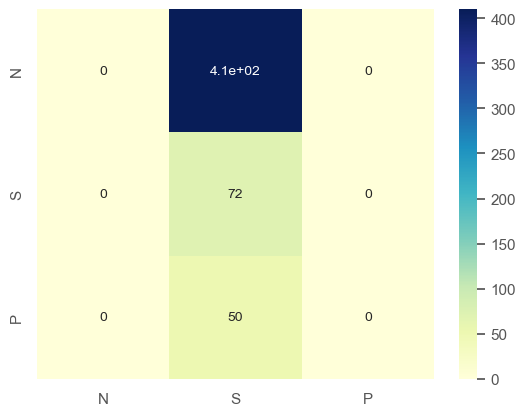

The number of epochs is : 15
The batch size is : 15
Epoch 1/15
107/107 [==============================] - 0s 885us/step - loss: 18658.7695 - accuracy: 0.7867
Epoch 2/15
107/107 [==============================] - 0s 903us/step - loss: 12171.0820 - accuracy: 0.7942
Epoch 3/15
107/107 [==============================] - 0s 913us/step - loss: 23134.1172 - accuracy: 0.7936
Epoch 4/15
107/107 [==============================] - 0s 911us/step - loss: 16615.5879 - accuracy: 0.7930
Epoch 5/15
107/107 [==============================] - 0s 888us/step - loss: 11606.4043 - accuracy: 0.8074
Epoch 6/15
107/107 [==============================] - 0s 924us/step - loss: 25730.0879 - accuracy: 0.7854
Epoch 7/15
107/107 [==============================] - 0s 848us/step - loss: 20934.5039 - accuracy: 0.7898
Epoch 8/15
107/107 [==============================] - 0s 892us/step - loss: 30299.8652 - accuracy: 0.7999
Epoch 9/15
107/107 [==============================] - 0s 841us/step - loss: 22473.7168 - accuracy: 0

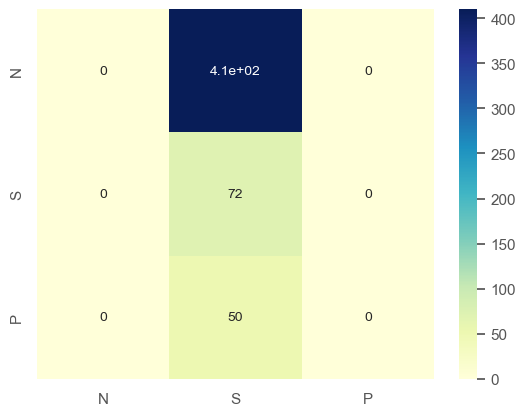

The number of epochs is : 15
The batch size is : 20
Epoch 1/15
80/80 [==============================] - 0s 899us/step - loss: 19192.2949 - accuracy: 0.8011
Epoch 2/15
80/80 [==============================] - 0s 886us/step - loss: 12368.9473 - accuracy: 0.7873
Epoch 3/15
80/80 [==============================] - 0s 911us/step - loss: 17830.7051 - accuracy: 0.7986
Epoch 4/15
80/80 [==============================] - 0s 924us/step - loss: 23604.3555 - accuracy: 0.7804
Epoch 5/15
80/80 [==============================] - 0s 924us/step - loss: 18599.0254 - accuracy: 0.8130
Epoch 6/15
80/80 [==============================] - 0s 911us/step - loss: 13703.8770 - accuracy: 0.7942
Epoch 7/15
80/80 [==============================] - 0s 899us/step - loss: 14144.8838 - accuracy: 0.7930
Epoch 8/15
80/80 [==============================] - 0s 899us/step - loss: 17726.9570 - accuracy: 0.7980
Epoch 9/15
80/80 [==============================] - 0s 911us/step - loss: 28596.8379 - accuracy: 0.7942
Epoch 10/15


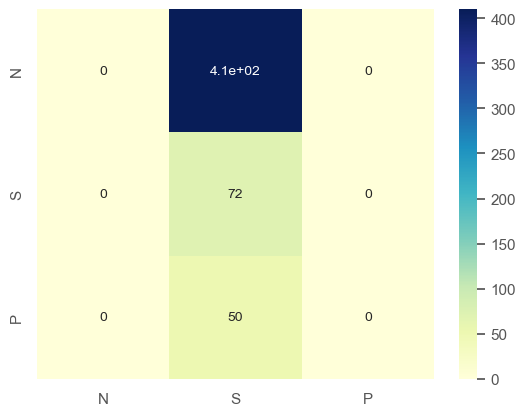

In [31]:
epochs = [5,10,15]
batch_sizes = [1,2,3,4,5,10,15,20]
table_results = np.zeros([(len(epochs)*len(batch_sizes)),3],)
c = 0
for aa in epochs:
    for bb in batch_sizes:
        print('The number of epochs is : '+str(aa))
        print('The batch size is : '+str(bb))
        classifier.fit(X_train, y_trainann, batch_size = bb, epochs = aa)

        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.7)

        recovered_y = np.zeros(532,)
        for i in range(0,532):
            for j in range(0,2):
                if (y_pred[i][j] == True) and j == 0:
                    recovered_y[i] = 1
                elif (y_pred[i][j] == True) and j == 1:
                    recovered_y[i] = 3            
        for i in range(0,532):
            if recovered_y[i] == 0:
                recovered_y[i] = 2

        from sklearn.metrics import confusion_matrix, accuracy_score
        cm = confusion_matrix(y_test, recovered_y)
        acc = accuracy_score(y_test, recovered_y)
        
        table_results[c][0] = aa
        table_results[c][1] = bb
        table_results[c][2] = acc
        c += 1
        print('The accuracy is : '+str(acc))   
        label = ["N","S","P"]
        sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
        plt.show()

Let's put this in a 3D representation to see if anything comes out immediatly.

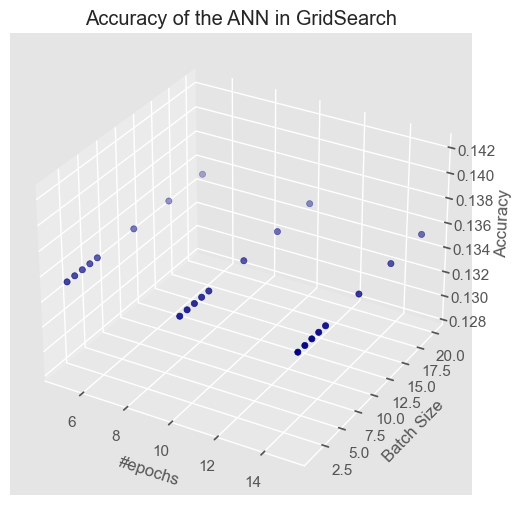

In [32]:
style.use('ggplot')
    
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')
loc = [1,2,3]
classes = ['Normal','Suspect','Pathologic']
    
x3d = table_results[:,0]
y3d = table_results[:,1]
z3d = table_results[:,2]

plot = ax1.scatter(x3d, y3d, z3d,c=z3d, cmap="jet")
ax1.set_xlabel('#epochs')
ax1.set_ylabel('Batch Size')
ax1.set_zlabel('Accuracy')


plt.title('Accuracy of the ANN in GridSearch')
plt.show()

Let's examine the table we made.

In [ ]:
table_results

The best results we get here are around  91.2% accuracy.  This is very far from the 98.9% accuracy we had with the optimized SVC. The SVC was extremely easy to optimize and is already built for these kind of problems. Indeed, the dataset is quite small, has barely any outliers and is overall very a "clean" one. All of these things make the SVC an ideal classifier for this problem. The ANN is slightly more difficult to tune because of its larger number of strong parameters and the time it takes to train. Furthermore the small size of the dataset that was an advantage for the SVC becomes an inconvenient for the ANN and makes it prone to overfitting.

A few other things that we could change to try to optimize the ANN would be the number of neurons per layer, the number of layers, type of activation functions, type of scaling for our data, etc. Since the computing time taken is higher for the ANN than it is for the SVC, we decided not to do this since our result of 98.9% accuracy for the SVC is already satisfactory.


---
Thanks for reading, I hope you learnt something.
All feedback is welcome !